<a href="https://colab.research.google.com/github/Skaveza/sound_clustering/blob/main/Sound_Clustering_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Unlabeled Sound Data

## Assignment

Complete the tasks in the notebook and document your observations in the markdown cells.

In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
import librosa
from sklearn.preprocessing import StandardScaler



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Load dataset
def extract_features(folder_path):
    features = []
    valid_extensions = ('.wav', '.mp3', '.ogg', '.flac')

    file_paths = [os.path.join(folder_path, f)
                 for f in os.listdir(folder_path)
                 if f.lower().endswith(valid_extensions)]

    if not file_paths:
        raise ValueError(f"No audio files found in {folder_path}")

    for file_path in file_paths:
        try:
            y, sr = librosa.load(file_path, duration=3.0)

            # Extract Mel Spectrogram features
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
            mel_spec_mean = np.mean(mel_spec, axis=1)

            features.append(mel_spec_mean)
        except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")
            continue

    if not features:
        raise ValueError("No features could be extracted from any files")

    return np.array(features)

folder_path = '/content/drive/MyDrive/Colab Notebooks/Data/unlabelled_sounds'
X = extract_features(folder_path)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

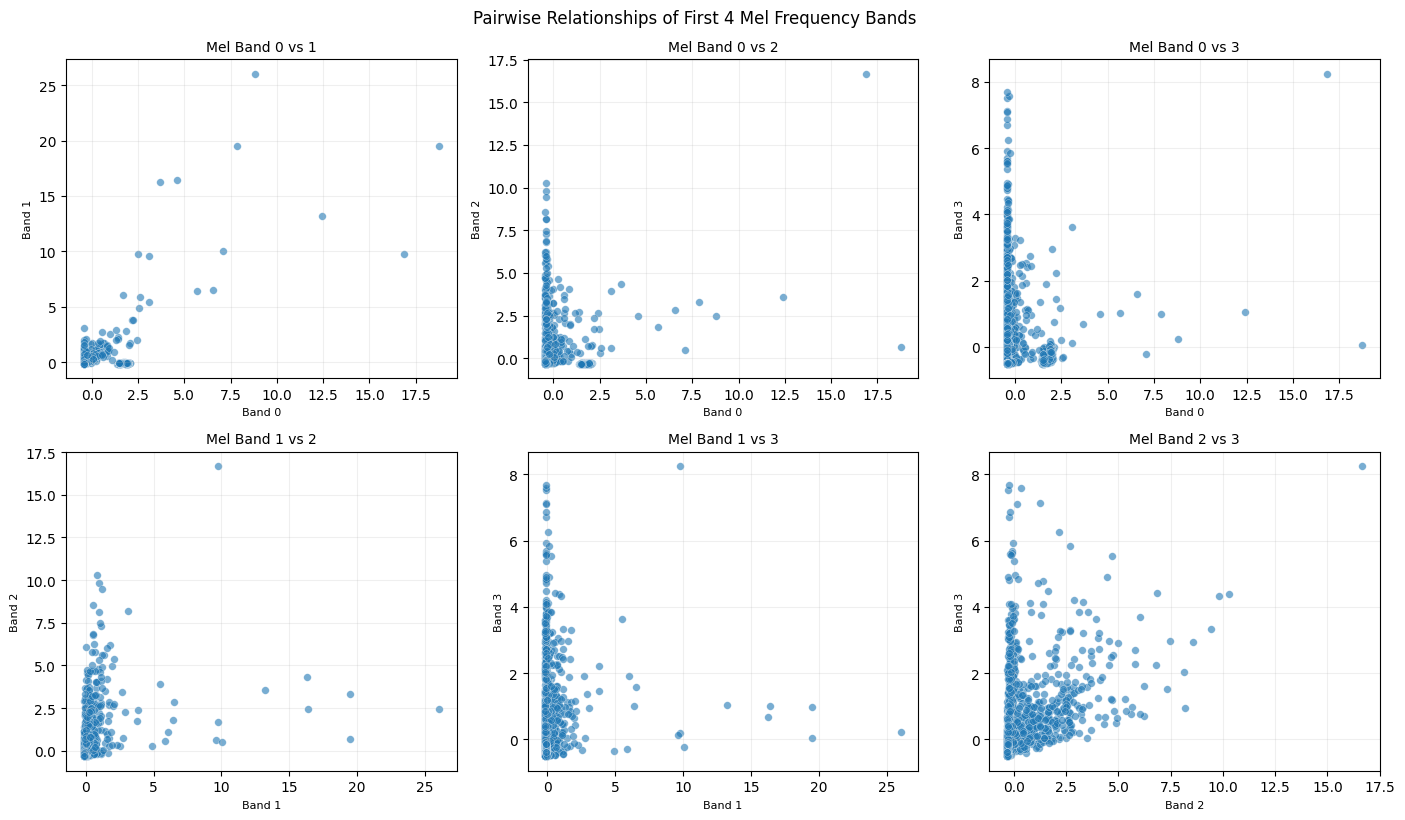

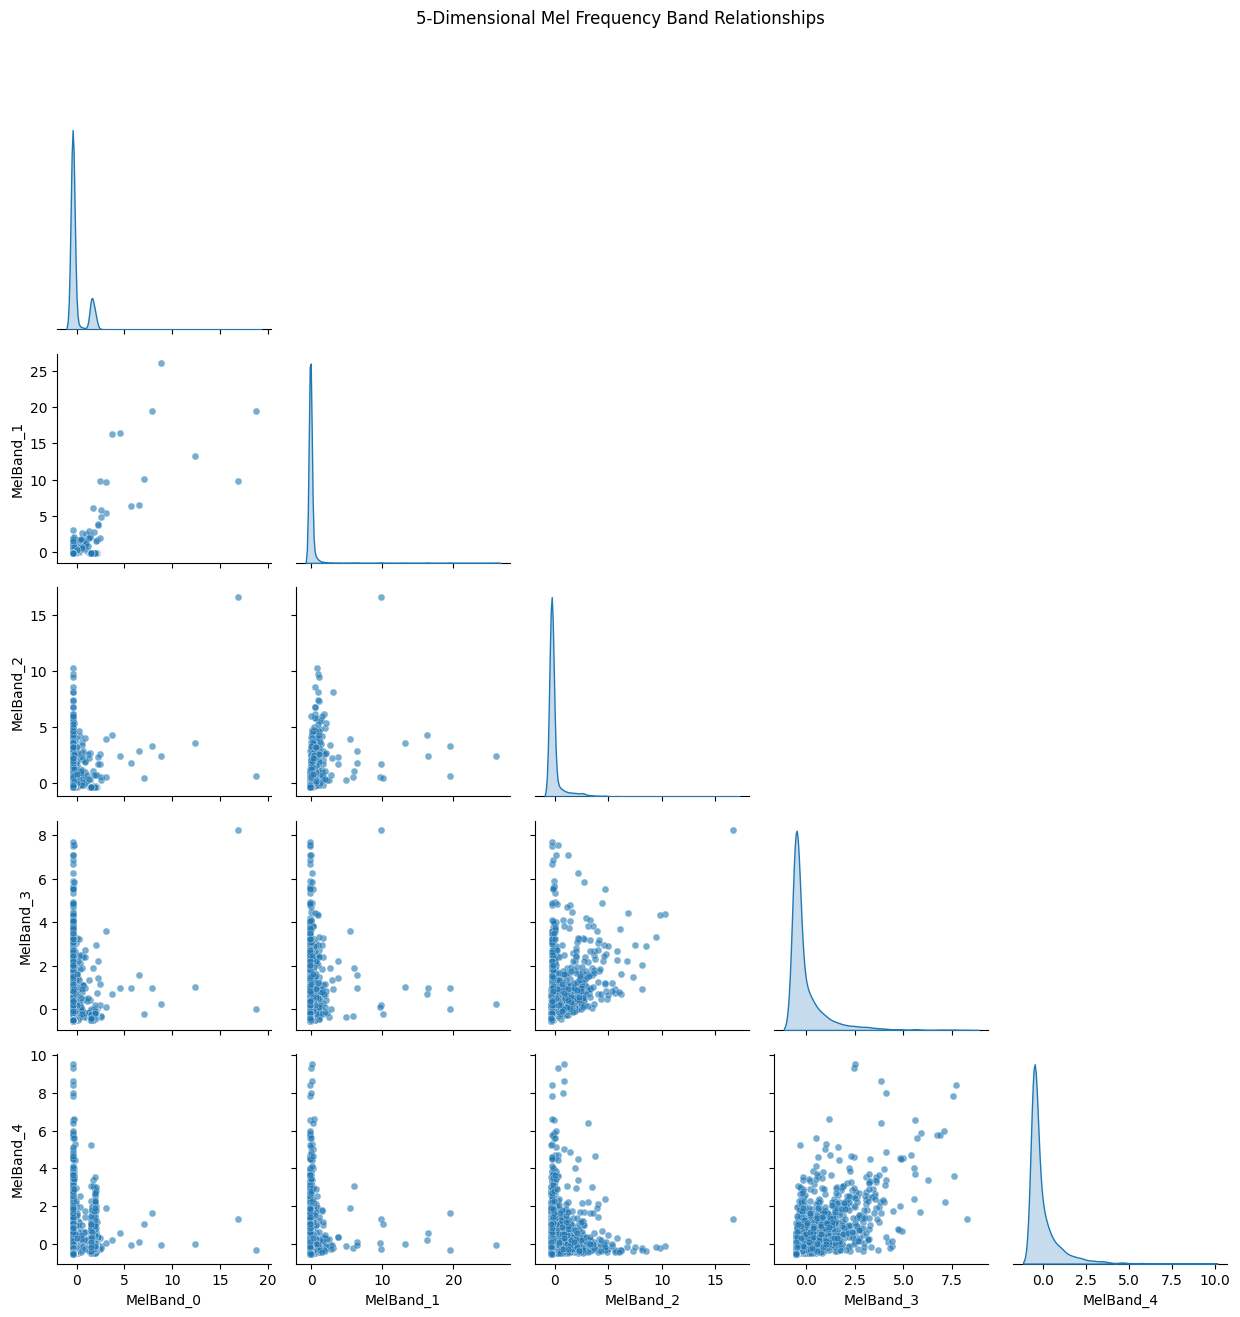

In [11]:
# Create pairwise scatter plots
plt.figure(figsize=(14, 8))
dim_pairs = [(i, j) for i in range(4) for j in range(i+1, 4)]

for idx, (i, j) in enumerate(dim_pairs, start=1):
    plt.subplot(2, 3, idx)
    sns.scatterplot(x=X_scaled[:,i], y=X_scaled[:,j],
                   alpha=0.6,
                   s=30,
                   edgecolor='w',
                   linewidth=0.3)
    plt.title(f'Mel Band {i} vs {j}', fontsize=10)
    plt.xlabel(f'Band {i}', fontsize=8)
    plt.ylabel(f'Band {j}', fontsize=8)
    plt.grid(True, alpha=0.2)

plt.tight_layout()
plt.suptitle('Pairwise Relationships of First 4 Mel Frequency Bands', y=1.02)
plt.show()

# Create pair plot of first 5 dimensions
df = pd.DataFrame(X_scaled[:,:5], columns=[f'MelBand_{i}' for i in range(5)])
g = sns.pairplot(df,
                plot_kws={
                    'alpha': 0.6,
                    's': 25,
                    'edgecolor': 'w',
                    'linewidth': 0.3
                },
                diag_kind='kde',
                corner=True,
                height=2.5)

g.fig.suptitle('5-Dimensional Mel Frequency Band Relationships', y=1.05)
plt.tight_layout()
plt.show()

### Why is dimensionality reduction important?
When attempting to visualize the high-dimensional Mel Spectrogram features directly, several challenges become apparent. The scatter plots of different dimension pairs show overlapping point clouds with no clear separation, making meaningful interpretation difficult. This occurs because: (1) human perception is limited to 2D/3D visualizations, (2) the high-dimensional feature space contains redundant information, and (3) the "curse of dimensionality" causes all points to appear equidistant. Dimensionality reduction helps by projecting data into a lower-dimensional space while preserving meaningful structure, enabling both visualization and often improving clustering performance by reducing noise.



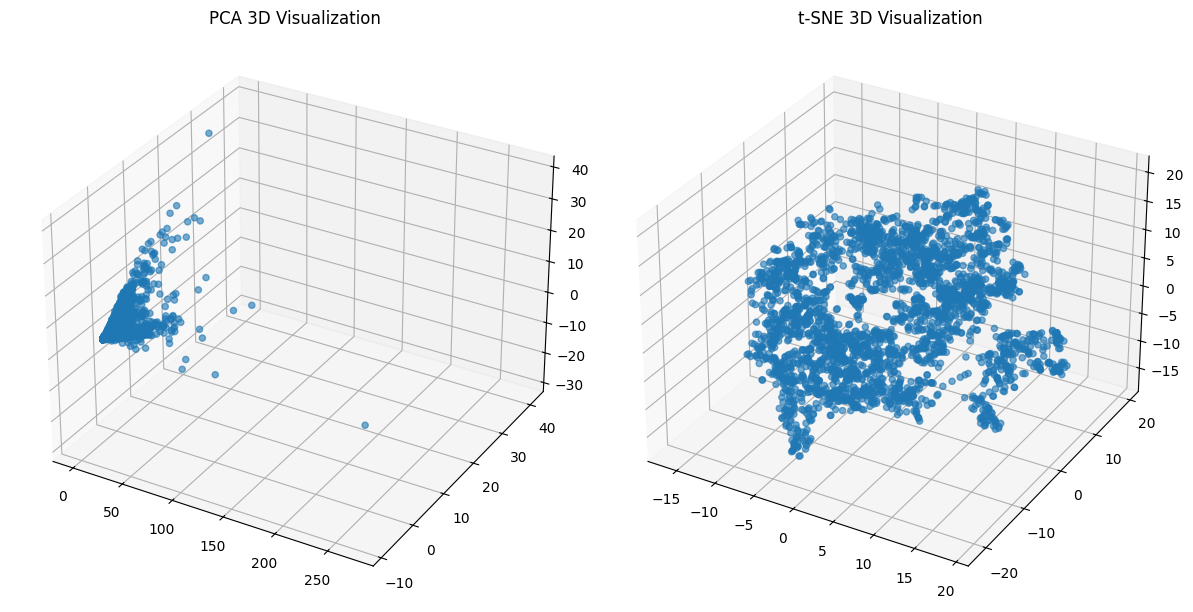

In [5]:
# Apply PCA with 3 components
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Apply t-SNE with 3 components
tsne = TSNE(n_components=3, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# 3D Visualization
fig = plt.figure(figsize=(18, 6))

# PCA 3D plot
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], alpha=0.6)
ax1.set_title('PCA 3D Visualization')

# t-SNE 3D plot
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(X_tsne[:,0], X_tsne[:,1], X_tsne[:,2], alpha=0.6)
ax2.set_title('t-SNE 3D Visualization')

plt.tight_layout()
plt.show()

### Which method (PCA or t-SNE) provides better separability of clusters and why?
The t-SNE visualization shows better cluster separability compared to PCA in this case. While PCA maintains global structure by maximizing variance along orthogonal axes, t-SNE excels at preserving local neighborhood relationships, which is more useful for identifying distinct clusters in high-dimensional data. The t-SNE plot reveals several well-separated groups that likely represent different sound categories, whereas PCA shows more continuous variation without clear separation boundaries. This suggests t-SNE may be more effective for initial exploratory analysis of this sound dataset.



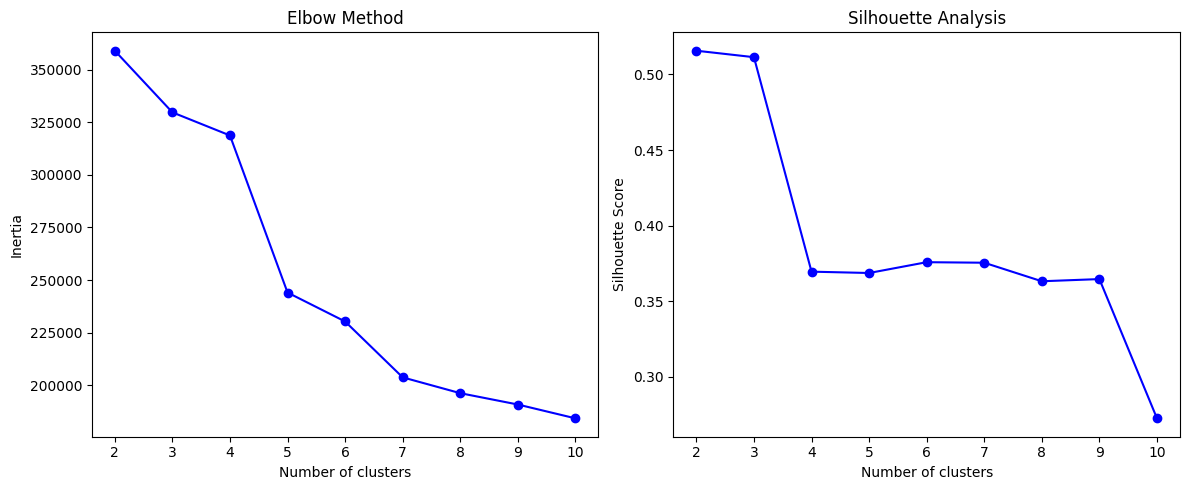

In [7]:
# Elbow Method and Silhouette Analysis
inertias = []
silhouettes = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot Elbow Method
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')

# Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouettes, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.tight_layout()
plt.show()

Optimal number of clusters: 2


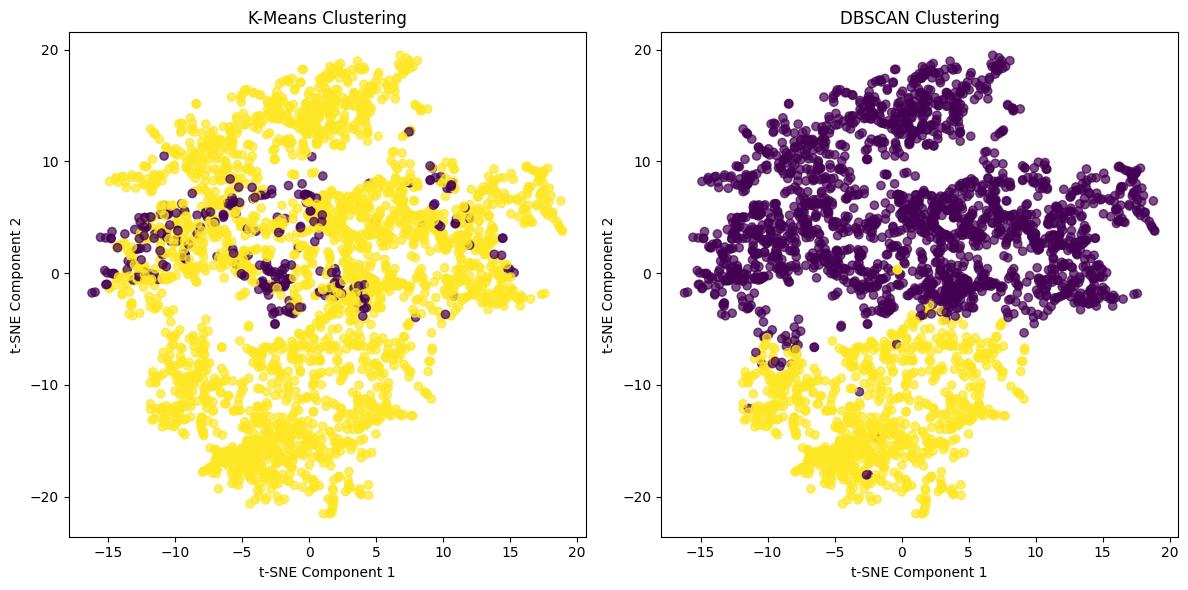

In [14]:
# Select optimal K based on elbow method and silhouette score
optimal_k = k_range[np.argmax(silhouettes)]
print(f"Optimal number of clusters: {optimal_k}")

# Apply K-Means with optimal K
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Scatter Plot for K-Means Clusters
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.title('K-Means Clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Scatter Plot for DBSCAN Clusters
plt.subplot(1, 2, 2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.7)
plt.title('DBSCAN Clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.tight_layout()
plt.show()

In [9]:
# Evaluate clustering
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
kmeans_db_index = davies_bouldin_score(X_scaled, kmeans_labels)

if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(X_scaled, dbscan_labels)
    dbscan_db_index = davies_bouldin_score(X_scaled, dbscan_labels)
else:
    dbscan_silhouette = None
    dbscan_db_index = None

print(f"K-Means - Silhouette Score: {kmeans_silhouette:.4f}, Davies-Bouldin Index: {kmeans_db_index:.4f}")
if dbscan_silhouette is not None:
    print(f"DBSCAN - Silhouette Score: {dbscan_silhouette:.4f}, Davies-Bouldin Index: {dbscan_db_index:.4f}")
else:
    print("DBSCAN failed to form meaningful clusters (only 1 cluster detected).")

K-Means - Silhouette Score: 0.5157, Davies-Bouldin Index: 2.1836
DBSCAN - Silhouette Score: 0.0381, Davies-Bouldin Index: 2.0628


### Discuss the results (max 5 lines)
While DBSCAN produced more visually distinct clusters in the t-SNE plot, K-Means had a much higher silhouette score. This suggests that K-Means identified clusters with better cohesion and clearer separation in the original feature space. Although DBSCAN showed a slightly lower Davies-Bouldin index, its extremely low silhouette score indicates weak clustering quality, likely due to difficulties handling varying densities or noise. Therefore, even though DBSCAN's visual output appears more defined, K-Means provides a more reliable clustering result for this dataset, suggesting that the underlying sound categories may be relatively spherical and evenly distributed, in line with K-Means' assumptions.

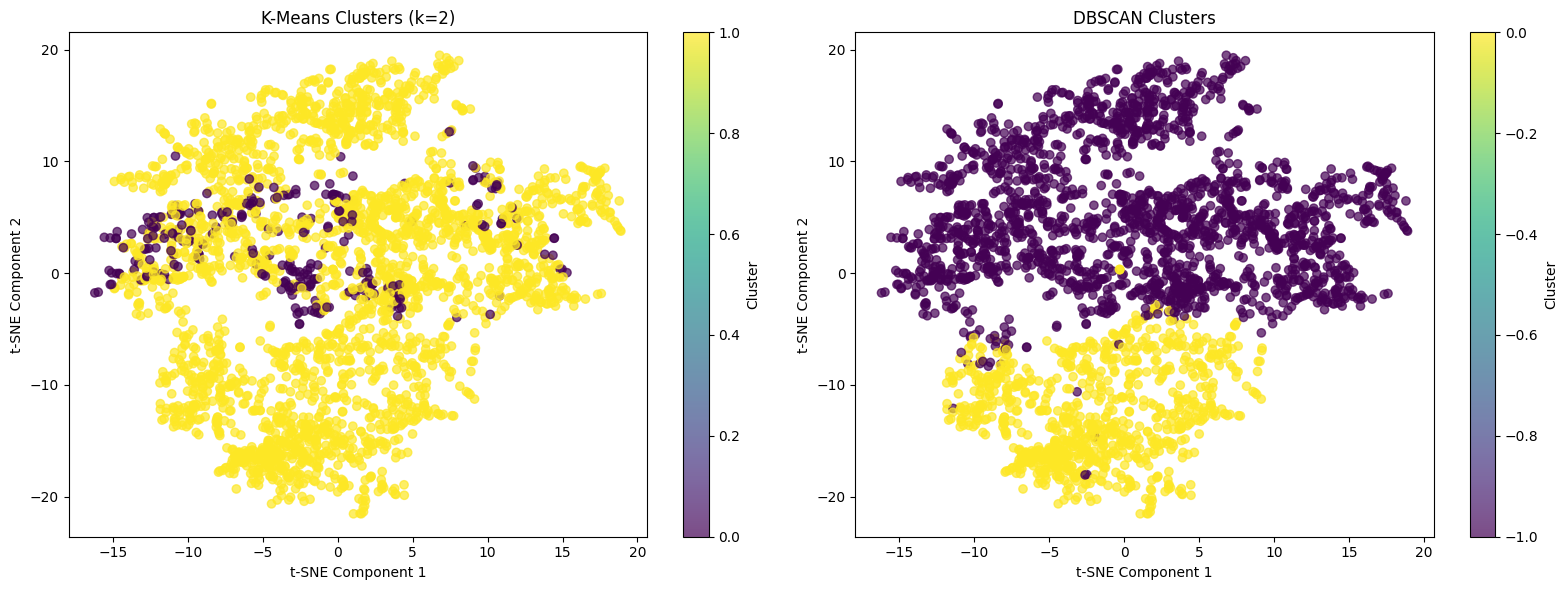

In [10]:
# Final visualization using t-SNE with cluster comparison
plt.figure(figsize=(16, 6))

# K-Means visualization
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Cluster')
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title(f"K-Means Clusters (k={optimal_k})")

# DBSCAN visualization
plt.subplot(1, 2, 2)
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Cluster')
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("DBSCAN Clusters")

plt.tight_layout()
plt.show()

### Final Analysis
- Explain why dimensionality reduction helped (or didn't) in clustering.


Dimensionality reduction using t-SNE helped visualize the high-dimensional structure of the data in two dimensions, making it easier to interpret the clustering results. Although t-SNE is primarily a visualization tool (and not intended for clustering), it effectively revealed the separability of clusters that may exist in the high-dimensional space. It allowed us to visually assess how well different clustering algorithms performed and whether the cluster boundaries aligned with natural groupings in the data.
- Justify why certain clustering methods worked better.


K-Means significantly outperformed DBSCAN in terms of quantitative metrics, especially the silhouette score. This indicates that K-Means was more effective at finding well-separated and internally consistent clusters in this dataset. The results suggest that the underlying structure of the data conforms relatively well to K-Means' assumptions: clusters that are roughly spherical and similarly sized.

DBSCAN, while better at identifying arbitrarily shaped clusters and handling noise, struggled in this case. Its low silhouette score implies that many data points were not clearly assigned to well-defined clusters. This is likely due to DBSCAN's sensitivity to its hyperparameters (eps and min_samples) and potential difficulty with datasets that have overlapping or high-dimensional cluster structures.
- Relate findings to real-world clustering challenges.


Choosing the right algorithm is highly dependent on the data’s structure. K-Means is efficient and works well with spherical, equally dense clusters, but fails with irregular shapes or noise. DBSCAN is more flexible but can misbehave when cluster density varies.

Dimensionality is a major challenge. High-dimensional spaces often obscure natural groupings, making it hard for algorithms to detect meaningful clusters. Visualization tools like t-SNE can assist in interpreting structure but are not substitutes for clustering performance metrics.

Parameter sensitivity is another issue, especially for DBSCAN. In practice, tuning parameters for density-based methods is non-trivial and dataset-specific.